In [1]:
from keras.datasets import mnist
import numpy as np
import tensorflow as tf
import random

#Load the dataset
(X_train, _), (_,_) = mnist.load_data()

#Normalize the images -convert pixel values from [0,255] to [-1, 1]
X_train = X_train / 127.5 -1

X_train = np.expand_dims(X_train, axis = 3)

print(X_train.shape)

(60000, 28, 28, 1)


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import LeakyReLU
from keras.optimizers.legacy import Adam

#Discriminator model
def create_discriminator():
    model = Sequential()

    model.add(Flatten(input_shape=(28,28,1)))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss = 'binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    return model

discriminator = create_discriminator()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533505 (2.04 MB)
Trainable params: 533505 

In [3]:
from keras.layers import Reshape
from keras.layers import Dense

#Generator model
def create_generator():
    model = Sequential()

    model.add(Dense(256, input_dim=100))
    model.add(LeakyReLU(0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(Dense(1024))
    model.add(LeakyReLU(0.2))
    model.add(Dense(784, activation="tanh"))
    model.add(Reshape((28,28,1)))

    return model

generator = create_generator()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 784)              

In [4]:
from keras.models import Model
from keras.layers import Input

#GAN model

def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return gan

gan = create_gan(discriminator, generator)
gan.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         1486352   
                                                                 
 sequential (Sequential)     (None, 1)                 533505    
                                                                 
Total params: 2019857 (7.71 MB)
Trainable params: 1486352 (5.67 MB)
Non-trainable params: 533505 (2.04 MB)
_________________________________________________________________


In [5]:
def train_gan(gan, generator, discriminator, epochs=2000, batch_size=128):
    for e in range(epochs):
        #Train the discriminator
        real_images = X_train[np.random.randint(0, X_train.shape[0], batch_size)]
        noise = np.random.normal(0,1, size=[batch_size, 100])
        generated_images = generator.predict(noise)
        X = np.concatenate([real_images, generated_images])
        y_dis = np.zeros(2*batch_size)
        y_dis[:batch_size] = 0.9 #label smoothing
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(X, y_dis)

        #Train the generator
        noise = np.random.normal(0, 1, size=[batch_size, 100])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)

        # Print losses
        if e%1000 == 0:
            print("Discriminator loss: ", d_loss, ", Generator loss: ", g_loss)
            # print("epoch: " + str(e))
train_gan(gan, generator, discriminator)



4/4 [==============================] - 0s 2ms/step
Discriminator loss:  [0.6806666851043701, 0.0625] , Generator loss:  0.6682816743850708
4/4 [==============================] - 0s 2ms/step
Discriminator loss:  [0.5742809772491455, 0.4921875] , Generator loss:  1.1840693950653076
4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 1ms/step


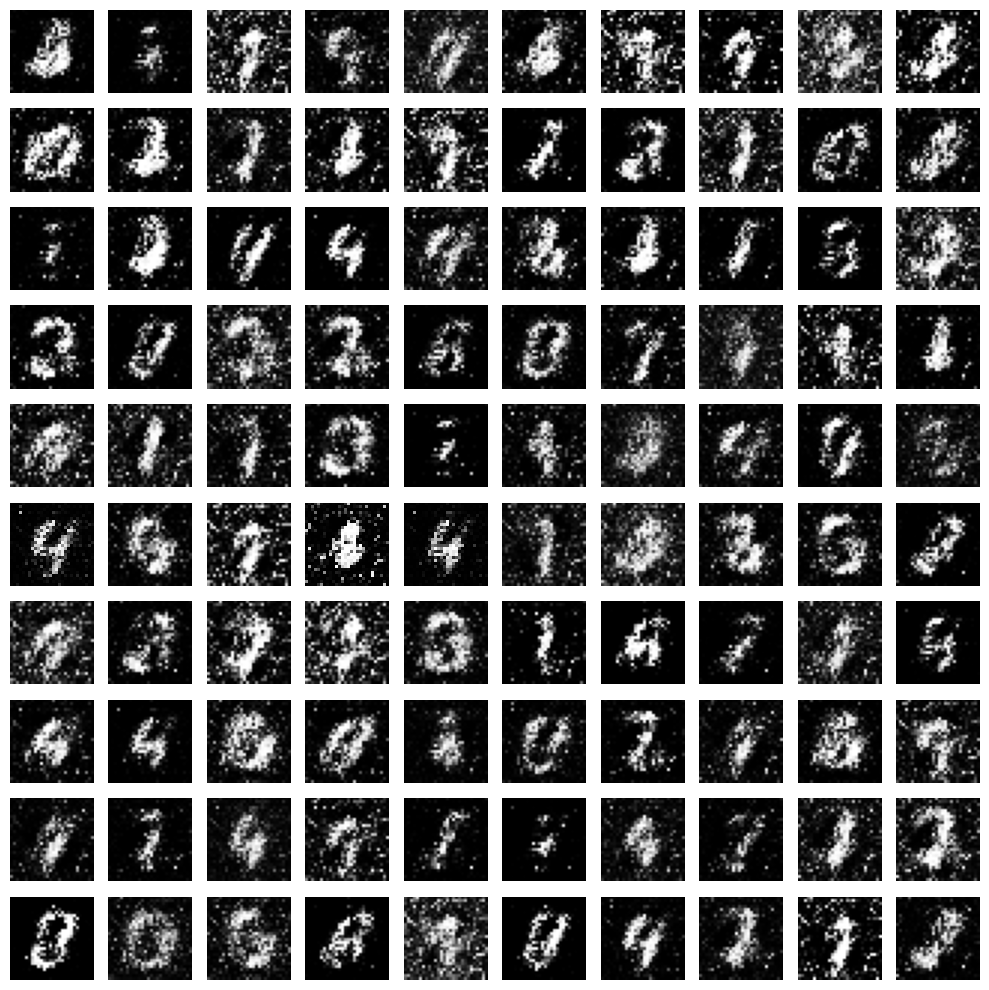

In [6]:
import matplotlib.pyplot as plt

def show_images(noise):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))

    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if generated_images.shape[3] == 1:
            plt.imshow(image.reshape((28, 28)), cmap='gray')
        else:
            plt.imshow(image.reshape((28, 28, 3)))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

noise = np.random.normal(0, 1, size=(100, 100))
show_images(noise)